In CH2 we explored regression. Now we explore another common supervised method, classification.

## MNIST

We will use MNIST data, which is iamges of digits written by high school students. Many students beginning ML or wondering how an algorithm will perform will use this dataset.

In [3]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

SK learn datasets often have similar structure including:
1. Descr - describing the dataset
2. Data key containing an array with one row per instance and one column per feature
3. Target key containing an array with labels

In [4]:
X,y = mnist["data"], mnist["target"]
#X.shape #(70000, 784)
y.shape

(70000,)

We see there are 70k images, 784 features. This is because there are 28x28 pixels, and each feature is the pixel intensity from white (0) to black (255).

We need to grab the feature vector and reshape it into a 28x28 array and display it using matplotlib's imshow() function.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
y[0]
#the above looks like a 5, and the label indicates it is a 5

'5'

In [17]:
#the label is a string, let's change to a #
import numpy as np
y=y.astype(np.uint8)

In [6]:
#let's start by making a test set
#this data is already splot into sets
#first 60k are the train, last 10k the test
X_train, X_test, y_train, y_test = X[: 60000], X[ 60000:], y[: 60000], y[ 60000:]

The training set is shuffled, which is good as it guaruntees cross-validation folds will be similar. Some algorithms are also sensitive to the order of training instances, and train poorly if too many similar instances in a row are shown.

## Training a binary Classifier

Let's simplify the problem and only try to classify whether the number is a 5 of not. We create the target vectors for this:

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We start with a Stochastic Gradient Descent classifier. It can handle large datasets efficiently because it deals with instances one at a time (suited for online learning).

In [30]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
#Now use it to predict
sgd_clf.predict([some_digit])
#evals to true for the digit tested
#now let's evaluate performance on the whole set

array([ True])

## Performance Measures

Evaluating a classifier is often more tricky than a regressor. There are more measures available

### Measuring Accuracy with CV

We can eval performance with cross-validation

**Implementing CV**
We may want more control over the CV process than CV's defaults. In such cases we can perform CV ourselves:


In [33]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 
skfolds = StratifiedKFold( n_splits = 3, random_state = 42) 
for train_index, test_index in skfolds.split( X_train, y_train_5): 
    clone_clf = clone( sgd_clf) 
    X_train_folds = X_train[ train_index] 
    y_train_folds = y_train_5[ train_index] 
    X_test_fold = X_train[ test_index] 
    y_test_fold = y_train_5[ test_index] 
    
    clone_clf.fit( X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict( X_test_fold) 
    n_correct = sum( y_pred == y_test_fold) 
    print( n_correct / len( y_pred))


    

0.95035
0.96035
0.9604


StratifiedKFold performs statified sampling to produce folds representative of ratios of each class. At each iteration the code creates a clone of the classifier, trains it on the folds, and makes predictions. The counts the number of correct predicts and outputs a ratio.

We can use cross_val_score() to eval the moel with K-fold CV.

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

We see the classifier scores at 95% + for all the folds. This seems exciting, but le's see how well the dumb classifier that just classifies everything as 'not-5' does:

In [39]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)



In [41]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We see even the dumb classifier gets 90-91% correct. This is because only 10% of images are 5s so if you guess something isn't 5 you will be right 90% of the time.

This is why accuracy isn't the preferred performance measure for classifiers especially with skewed datasets.

### Consusion Matrices

A better way to eval performance is with a confusion matrix. It counts the number of times instances of A are classified as B. EG the number of times a 5 is classed as a 3 in MNIST.

You first need to have a set of predicions so they can be compared to targets. We can use the cross_val_predict function to do this on the train set

In [42]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

the predict function is similar to cross val score, but performs CV and returns the predictions mae for each test fold. So you get the clean prediction for each instance (clean meaning the model hasn't seen the data during training).

Now we get the matrix:

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

each row above is a class, and the columns are the predicted class. The first row is instances that aren't 5 (negative class). We see 53892 of these were correctly classified (true negative), while 687 were false neatives. We then see 3530 were correctly identified as 5s while 1891 were false positives.

A perfect classifier would have [[##, 0], [0,##]]

The above provides a lot of info, but sometimes we want a more concise metric. We can look at accuracy of the positive predictions, which we call the precision of the classifier.

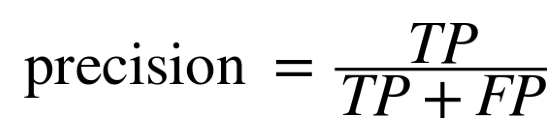


Precision is also used with recall, also called sensitivity or true positive rate. This is the ratio of true positive instances correctly detected:

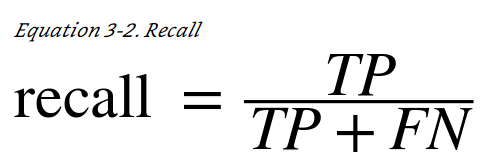



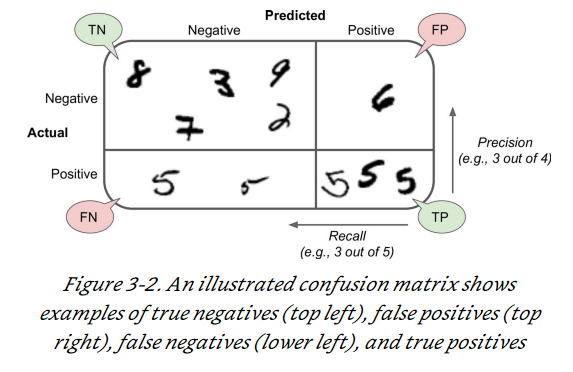

### Precision and recall

Sklearn provides functions to computer metrics like precision and recall

In [44]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [45]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

with the above emtrics we see that the model doesn't look as good as the accuracy stat made it seem. When it claims an image is a 5 it is right 83% of the time, and it only detects 65% of the 5s.

Precision and recall can be combined to a sinel metric call the F1 score, in particular if ou want a simple you to compare classifiers. F1 is the harmonic mean of the two metrics; it gives more weight to low values and thus high F1 scores only occur if both metrics are high:

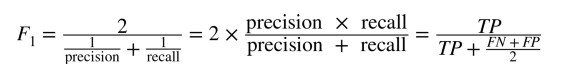

In [48]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 favors classifiers with similar precision and recall. However sometimes you care more about precision or more about recall. EG if you make a classifier to videos that are unsafe for kids you would prefer it to reject many good videos (low recall) and only keep safe ones (higher precision) rather than a classifier with higher recall that lets some bad videos show up. Or you may be training a system to detect shoplifting in images: it is likely ok if you have 30% precisoin as long as it has 99% recall (there will be some false alarms but all the shoplifters will be caught).

You can't have it both ways: increasing precision reduces recall and vice versa. This is the precision/recall tradeoff.

### Precision/Recall Trade-off

To understand the tradeoff let's look at how SGD makes classifications.

For each instance it computes a score based on a decision function. If the score > threshold it assigns a positive class, otherwise it gives a negative class. Below we see digits with lowest score on left to highest on the right.

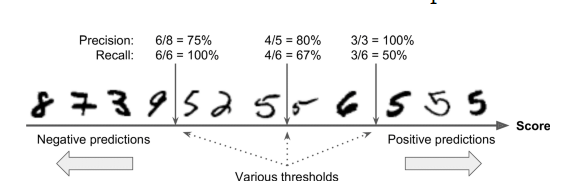

If the threshold was in the midle, we will find one false positive in the results and a precision of 80% and recall of 67% [4/6].

If we move the threshold right, we get a precision of 100, but a recall of 50%. To the left we would get precision of 75% and a recall of 100%.

We can't change the threshold directly, but we can access the decision scores it uses: we can call the decision_function() method which returns scores for each instance and then we can use anythreshold based on the scores.

In [50]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [55]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Using a threshold of 0, we get true. Raising the thshold above 2164 will yield a false result.

How can we decide what threshold to use?

We can use cross_val_predict to get scores of all insances, but specify we want to return the decision function:

In [60]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [62]:
#now use precision_recall_curve() to compute precision and recall for all thresholds.

from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5, y_scores)

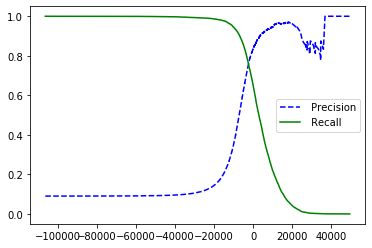

In [74]:
#now use matplotlib to plot the above.

def plot_precision_recall_vs_threshold( precisions, recalls, thresholds): 
    plt.plot( thresholds, precisions[:-1], "b--", label =" Precision") 
    plt.plot( thresholds, recalls[:-1], "g-", label =" Recall") 
    # highlight the threshold and add the legend, axis label, and grid 
    plt.legend()

plot_precision_recall_vs_threshold( precisions, recalls, thresholds)  
plt.show()



**Note: Precision curve above is bumpier than the recall curve. Precision may go down when raising the threshold. EG from the threshold grpah above, we see that if we moved the threshold from the center to one digit right precision will go from 80% to 75%. Recall can only go down when threshold is increased, though so it is smoother.**

You can also select a good recall/precision tradeoff by plotting precision aginst threshold

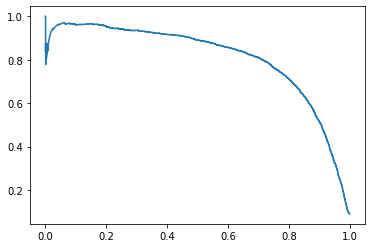

In [76]:
plt.plot(recalls, precisions)

We see that precision really starts to fall around the 80% mark. we will want to select a trade-off just before that drop, eg around 60%, but the choice depends on the project.

Suppose we knew we wanted a 90% precision. We could use np.argmax() to find the first index of that value:

In [79]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [81]:
y_train_pred_90 = (y_scores >=threshold_90_precision)

In [85]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [87]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

now we have a classifier with 90% precision, and we can create classifiers with the exact precision we want. However, a high precision classifier may not be useful if recall is too low!

### The ROC Curve

The receiver operating characteristic curve is another common tool used with binary classifiers. Similar to the p/r curve but instead plots TP rate against FP rate [1-TN]. TN rate is also known as specificity. This this curve plots sensitivity (recall)( vs 1-specificty. We use roc_curve to do this:

In [89]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5, y_scores)

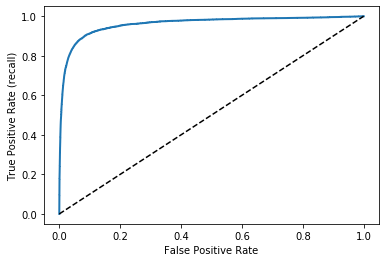

In [100]:
#now plot with matplotlib

def plot_roc_curve( fpr, tpr, label = None): 
    plt.plot( fpr, tpr, linewidth = 2, label = label) 
    plt.plot([ 0, 1], [0, 1], 'k--') 
    # Dashed diagonal [...] # Add axis labels and grid
    plt.ylabel('True Positive Rate (recall)')
    plt.xlabel('False Positive Rate')

plot_roc_curve( fpr, tpr) 
plt.show()



Again we see the higher the recall, the more false positives.

One way to compare classifiers is to measure the area under curve. Perfect classifiers will have ROC AUC = 1, and a random classifier will have AUC of 0.5.

In [103]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note: Since ROC is siimlar to the PR curve you may wonder which to use. You should prefer PR whenever the positive class is rare or you care more about FP rate than FN rate. Otherwise use AUC. EG looking at our AUC rurve we may think the classifier is really good but this is because there are few 5s compared to non-5s. The PR curve makes it clear there is room for improvement [curve could be closer to the top-right-corner.**

Now let's train a Random forst and compare irs ROC to the SGD.

Random forest doesn't have a decision function, but has a predict_proba() function that operates similarly and shows us the instance and probability of belonging to the class.

In [105]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3, method = "predict_proba")

C:\Users\Allan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Allan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Allan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The roc_curve expects labels and scores, but we can feed it probabilities.

In [108]:
y_scores_forest = y_probas_forest[:,1]
#score = proba of positive class
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5, y_scores_forest)

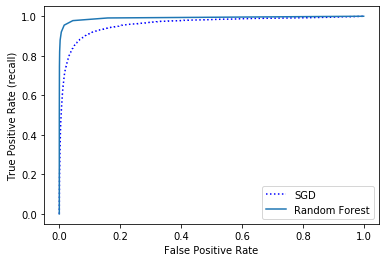

In [112]:
plt.plot(fpr,tpr,"b:", label="SGD")
plt.plot(fpr_forest,tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.ylabel('True Positive Rate (recall)')
plt.xlabel('False Positive Rate')
plt.show()


We see that the random forest is superior.

In [114]:
roc_auc_score(y_train_5, y_scores_forest)
#precision of 99%, reacll of 87%

0.9920527492698306

## Multiclass Classification

Binary classifiers distinguish between two classes, multiclass classifiers can distinguish between more than 2.

Some algoirthms like SGD, RF, naive bayes are capable of doing this while others like Logistic regression or SVM are strictly binary.

You can implement methods to perform multiclass classification with binary classifiers.

One way is to classify the digit images into 10 classes is to train 10 binary classifiers, one for each digit. Then get decision scores for each classifier and select the class whose classier output has the highest score. This is called *one vs the rest strategy (OVR)*. 

You can also train a binary classifier for every pair of digits: one for 0 and 1, another for 0 and 2, 1 and 2, etc. This is one v one strategy. This will mean you need to train a lot of classifiers, and then pick the class that wins the most 'duels' in the system. The main advantage of this is the classifer only needs to be trained on the part of the training set for the two classes it must distinguish.

Some algorithms like SVM scale poorly with the size of the training set. For these, OvO is preferre because it is faster to train on many small training sets than on larger sets. For most classification algorithms though, OvR is preffered.

SKlearn detects when you are trying to use a binary algorithm for multi classification, and runs OvR or OvO. Let's try this using a SVM.

In [7]:
from sklearn.svm import SVC
svm_clf=SVC()

In [ ]:
svm_clf.fit(X_train,y_train)

C:\Users\Allan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
svm_clf.predict([some_digit])

Now the code is training SVC on the set to target 0-9 classes instead of 5 or not 5. It then makes a prediction. It does this with OvO.

We can call the decision_function() and see 10 scores, one per class:

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_
svm.clf.classes_[5]

We see the algorithm correctly detects the image of some_digit as 5.

We can force SKLean to use OVO or OVR, based on our choice. We can use the OneVsOneClassifier or OneVsRestClassifier clases. 

EG for OvR:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier( SVC()) 
ovr_clf.fit( X_train, y_train) 
ovr_clf.predict([ some_digit]) 
len( ovr_clf.estimators_)



In [ ]:
sgd.clf.fit(X_Train, y_train)
sgd_clf.predit([some_digit])

Noe that SKlearn doesn't need to run OvR or OvO on the SGD because it can classify multiple classes on its own. It's decision_function will return one value per class. Let's look at it:

In [ ]:
sgd_clf.decision_function([some_digit])

We see the classifier is confident that class 5 is the correct answer. we can use cross_val_score() to evaluate accuracy

In [ ]:
cross_val_score(sgd_clf,X_train,y_train, cv=3, scoring="accuracy")
#85%
#a dumb classifier would get 10%
#we can do better by scaling the inputs

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
#89%+ scores now!

## Error Analysis

Assuming we have now found a promising model, we want to find ways to improve it. One way to do so is analyzing errors. First we look at cross_validation_predict() and the confusion_matrix().

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

the above is a large matrix. We can convert it to an image representation with matplotlib:

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

the above matrix looks good since most mages are on the main diagonal and were thus correctly classified. The 5s are a bit darker, which could mean there are fewer 5 images or that the classifier doesn't perform well on 5s. We can verify this.

we can focus on and plot the errors. Firs we divide each value in the confusion matrix by # of images in the corresponding class so we can find the error rates instead of absolute #s.

In [ ]:
import numpy as np
row_sums = conf_mx.sum(axis=1, keepims=True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
#fill diagonal with 0s to keep only errors
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

We see the types of errors now. Each row is the class while columns are predicted class. We see that 8 is bright, so many images are misclassified as 8. However true values of 8 are often classified correctly. We also see 3 and 5 often get confused with each other in the system.

Now we have some insights to improve the classifier. We should spend time on reducing false 8s. We could get more data that looks like 8 but isn't, or get new features to help the classifier [eg count the number of closed loops in the image]. Or we could preprocess images to make patterns, like loops, stand out.

We can also classify individual errors to gain insights into why failures occur. this is more time-consuming and difficult. EG we could plot examples of 3s and 5s.

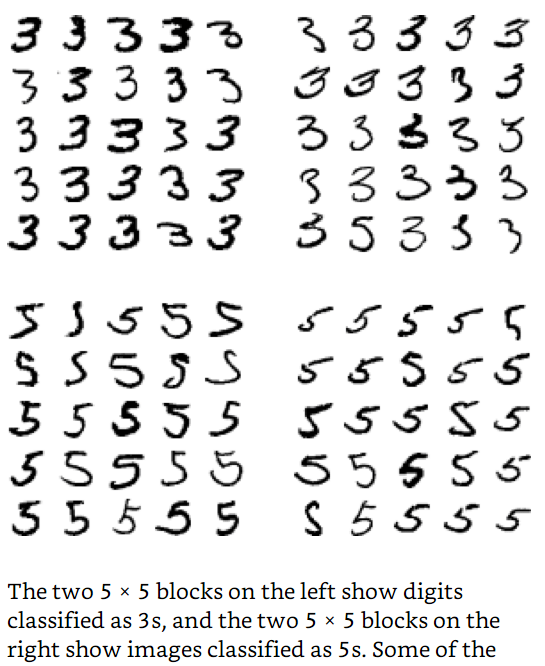

In the above we could see some examples are just terribly written and truly indiscernable. However many appear to be obvious errors.

Why the mistake? Because the SGD is a linear model and assigns a weigh per class to a pixel. It then sums up the weighted pixel intensities to score each class. Since 5s and 3s vary little by pixel it is easier to confuse them.

The main difference is the line that joins the top line to bottom arc. If we draw a 3 slightly to the left then it may look like a 5 by pixel weight. One thing we could do is prprocess the images so they are centered and not rotated.

## Multilabel Classification

Until now we have assigned each instance to one class. Sometimes we may need to output multiple classes per instance. EG a face-recognition algorithm. If it recognizes multiple people in an image,  it should attach one tag per person. Or if it sees A, not B, and C it should output [1,0,1]. This is called a multilabel classification system.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train > = 7) 
y_train_odd = (y_train % 2 = = 1) 
y_multilabel = np.c_[ y_train_large, y_train_odd] 
knn_clf = KNeighborsClassifier() 
knn_clf.fit( X_train, y_multilabel)

The above creates an array with two labels for each image. First digit indivates if the number is large (7+), the second if the number is odd or not.

Then it creates a KNN instance to make a prediction of whether the image is a large, odd/even #.

There are many ways to evaluate a multilabel classifier, and the right metric depends on the project.

We could measure F1 score for each label and compute an average:

In [ ]:
y_train_knn_pred = cross_val_predict( knn_clf, X_train, y_multilabel, cv = 3)
f1_score( y_multilabel, y_train_knn_pred, average =" macro")



The above assumes all labels are equally important, but this may not be true. EG if there are more pictures of A than of B/C, you many wan to give more weight on the classifier's score on pictures of A. We can give each label a weight accordingly in the above code to do so

## Multioutput Classification

This is the final type of classification we will discuss. It is a generalization of the multilabel classification where each label can be multiclass (can have more than two possible values).

EG we can build a system to reduce noise from images. We input a noisy image, and will output a clean image similar to the the format of MNIST images.

The classifier's output is multlabel (one label per pixel) and each label ranges from 0-255. Thus it is a multioutput system.

We start with a test set:



In [ ]:
noise = np.random.radint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.radint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test



We can look at an image from the test set [this is snooping, bad in general]

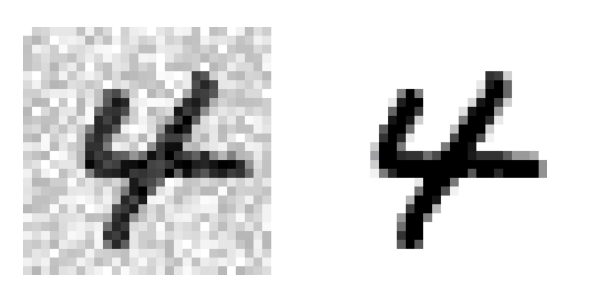

The left is the noisy image and the right is the target.  Now let's train the classifier to clean this image:

In [ ]:
knn_clf.fit( X_train_mod, y_train_mod) 
clean_digit = knn_clf.predict([ X_test_mod[ some_index]]) 
plot_digit( clean_digit)



This looks much better now. 

Now we know how to select good metrics, pick the PR trade-off, compare classifiers, and generally build good classification systems.